In [379]:
from tensorflow.keras.datasets import cifar10

In [380]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [381]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [382]:
import torch

In [383]:
print(x_train.min(), x_train.max(), x_train.dtype)

0 255 uint8


In [384]:
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

In [385]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [386]:
import numpy as np

# shape: (50000, 32, 32, 3)
mean = x_train.mean(axis=(0,1,2))
std  = x_train.std(axis=(0,1,2))

print("Mean:", mean)
print("Std:", std)

Mean: [0.4914009  0.48215896 0.4465308 ]
Std: [0.24703279 0.24348423 0.26158753]


In [387]:
x_train = (x_train - mean) / std
x_test  = (x_test - mean) / std

In [388]:
import numpy as np

# shape: (50000, 32, 32, 3)
mean = x_train.mean()
std  = x_train.std()

print("Mean:", mean)
print("Std:", std)


Mean: -2.2014904e-06
Std: 1.0000018


In [389]:
print(x_train.min(), x_train.max(), x_train.dtype)

-1.9892132 2.126795 float32


In [390]:
x_train = torch.tensor(x_train).permute(0, 3, 1, 2)
y_train = torch.tensor(y_train).long().squeeze()

x_test = torch.tensor(x_test).permute(0, 3, 1, 2)
y_test = torch.tensor(y_test).long().squeeze()

In [391]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([50000, 3, 32, 32]) torch.Size([50000])
torch.Size([10000, 3, 32, 32]) torch.Size([10000])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9892132..2.0945828].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9098397..2.1008174].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6581262..2.126795].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7708685..1.7254639].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9892132..2.0429575].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.899717..2.0112083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8622158.

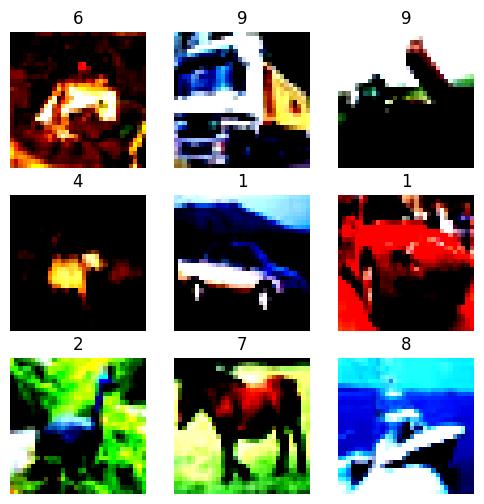

In [392]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[i].permute(1,2,0))
    plt.title(int(y_train[i]))
    plt.axis("off")
plt.show()

In [393]:
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(x_train, y_train)
test_dataset  = TensorDataset(x_test, y_test)

In [394]:
from torch.utils.data import DataLoader
batch_size = 64  # 4GB GPU pe safe

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

In [395]:
images, labels = next(iter(train_loader))
print(images.shape, labels.shape, images.dtype, labels.dtype)

torch.Size([64, 3, 32, 32]) torch.Size([64]) torch.float32 torch.int64


In [396]:
import torch
print(torch.__version__)
print("torch.version.cuda =", torch.version.cuda)

2.8.0+cpu
torch.version.cuda = None


In [397]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

False
0
No GPU


In [398]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1, bias=False), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32->16

            nn.Conv2d(32, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16->8

            nn.Conv2d(64, 128, 3, padding=1, bias=False),
            nn.BatchNorm2d(128), 
            nn.ReLU(),
            nn.MaxPool2d(2),  # 8->4


        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*4*4, 256), 
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN()

In [399]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay=5e-4)

In [400]:
def train_one_epoch(model, loader):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for x, y in loader:
        x, y = x, y

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    return total_loss / total, correct / total


@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    for x, y in loader:
        x, y = x, y

        logits = model(x)
        loss = criterion(logits, y)

        total_loss += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    return total_loss / total, correct / total

In [ ]:
import torch

train_losses, test_losses = [], []
train_accs, test_accs = [], []

best_acc = 0.0
epochs = 20

for ep in range(1, epochs + 1):

    # Change LR at epoch 10
    if ep == 10:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 3e-4
        print("LR reduced to 3e-4")

    tr_loss, tr_acc = train_one_epoch(model, train_loader)  
    te_loss, te_acc = evaluate(model, test_loader)

    train_losses.append(tr_loss)
    test_losses.append(te_loss)
    train_accs.append(tr_acc)
    test_accs.append(te_acc)

    print(
        f"Epoch {ep:02d} | Train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
        f"Test loss {te_loss:.4f} acc {te_acc:.4f}"
    )

    if te_acc > best_acc:
        best_acc = te_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("Best model saved")

Epoch 01 | Train loss 1.5940 acc 0.5065 | Test loss 1.3294 acc 0.6485
Best model saved
Epoch 02 | Train loss 1.3423 acc 0.6420 | Test loss 1.1801 acc 0.7079
Best model saved
Epoch 03 | Train loss 1.2502 acc 0.6901 | Test loss 1.1418 acc 0.7323
Best model saved
Epoch 04 | Train loss 1.1897 acc 0.7224 | Test loss 1.1205 acc 0.7355
Best model saved
Epoch 05 | Train loss 1.1425 acc 0.7462 | Test loss 1.0565 acc 0.7712
Best model saved
Epoch 06 | Train loss 1.0998 acc 0.7677 | Test loss 1.0462 acc 0.7790
Best model saved
Epoch 07 | Train loss 1.0673 acc 0.7832 | Test loss 1.0399 acc 0.7805
Best model saved
Epoch 08 | Train loss 1.0415 acc 0.7964 | Test loss 1.0210 acc 0.7918
Best model saved
Epoch 09 | Train loss 1.0158 acc 0.8094 | Test loss 1.0363 acc 0.7820
LR reduced to 3e-4
Epoch 10 | Train loss 0.9096 acc 0.8651 | Test loss 0.9488 acc 0.8209
Best model saved
Epoch 11 | Train loss 0.8739 acc 0.8827 | Test loss 0.9520 acc 0.8207
Epoch 12 | Train loss 0.8499 acc 0.8946 | Test loss 0.9440

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend(); plt.title("Loss"); plt.show()

plt.figure()
plt.plot(train_accs, label="train acc")
plt.plot(test_accs, label="test acc")
plt.legend(); plt.title("Accuracy"); plt.show()

In [ ]:
best_path = "best_model.pth"

# new fresh model object (same architecture)
best_model = SimpleCNN()
best_model.load_state_dict(torch.load(best_path))
best_model.eval()

best_test_acc = evaluate(best_model, test_loader)  # tumhara evaluate fn
print("Best checkpoint test acc:", best_test_acc)